In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [2]:
# import the train_test.csv
df = pd.read_csv('../data/train_test.csv')

In [3]:
# get the list of the ID from the train_test.csv (also having problem to drop duplicates)
subset = df[['id','los_icu_class']].copy()
subset.drop_duplicates(inplace=True)

print('Dimension: ', subset.shape)

Dimension:  (16322, 2)


In [4]:
# import the notes_embedded.csv
notes = pd.read_csv('../data/notes_embedded.csv')
notes.head()

,id,text,los_icu,icu_death,text_embeddings
0,20001305,INDICATION: ___ with copd in resp distress in...,2.78,1,[[ 4.95544821e-02 -3.71760167e-02 -1.27426326e...
1,20001361,CHEST X-RAY DATED ___.\n\nCOMPARISON: None.\n...,6.05,0,[[ 7.76797682e-02 -3.10484290e-01 -2.07543001e...
2,20001770,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,2.87,0,[[ 1.32888228e-01 -1.91068441e-01 -2.99163219e...
3,20002506,EXAMINATION: CTA HEAD AND CTA NECK Q16 CT NEC...,6.56,0,[[ 4.52079531e-03 -2.32567102e-01 2.54237894e...
4,20003425,ADDENDUM Findings were communicated to the EN...,4.00,0,[[ 1.22243397e-01 -2.15054199e-01 -6.55379891e...


In [5]:
# merge the dataset based on the ID in train_test.csv
notes_update = pd.merge(subset, notes, on='id', how='left')
print('Dimension of the dataset:', notes_update.shape)
display(notes_update.head())

Dimension of the dataset: (16322, 6)


,id,los_icu_class,text,los_icu,icu_death,text_embeddings
0,20001305,less than 3 days,INDICATION: ___ with copd in resp distress in...,2.78,1,[[ 4.95544821e-02 -3.71760167e-02 -1.27426326e...
1,20001361,greater than or equal to 3 days,CHEST X-RAY DATED ___.\n\nCOMPARISON: None.\n...,6.05,0,[[ 7.76797682e-02 -3.10484290e-01 -2.07543001e...
2,20001770,less than 3 days,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,2.87,0,[[ 1.32888228e-01 -1.91068441e-01 -2.99163219e...
3,20002506,greater than or equal to 3 days,EXAMINATION: CTA HEAD AND CTA NECK Q16 CT NEC...,6.56,0,[[ 4.52079531e-03 -2.32567102e-01 2.54237894e...
4,20003491,less than 3 days,EXAMINATION: Chest radiograph\n\nINDICATION: ...,2.54,0,[[ 7.84905553e-02 -1.51299506e-01 2.41509974e...


In [6]:
def convert_to_np(string):
    ss = string.strip('[]').split()
    return np.array(ss, dtype=float)

In [7]:
# apply the 'convert_to_np' function t convert text_embeddings into numpy array
notes_update['text_embeddings'] = notes_update['text_embeddings'].apply(convert_to_np)

### LOS Prediction

In [8]:
# helper function to plot ROC curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models, Xtest, ytest):
    plt.figure(figsize=(10,8))
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
        # for neural network
        else:
            model.eval()
            Xtest_tensor = torch.FloatTensor(Xtest)
            with torch.no_grad():
                outputs = model(Xtest_tensor)
                ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()

In [9]:
# helper function to check metrics
rom sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

def eval_metrics(models, Xtest, ytest):
    res_df = []
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
            ypred = model.predict(Xtest)
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
            ypred = model.predict(Xtest)
        # for neural network
        else:
            model.eval()
            with torch.no_grad():
                Xtest_tensor = torch.FloatTensor(Xtest)
                outputs = model(Xtest_tensor)
                ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function
                ypred = (ypred_proba >= 0.5).astype(int)

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)
        precision = precision_score(ytest, ypred, average='macro', zero_division=0)
        recall = recall_score(ytest, ypred, average='macro', zero_division=0)
        f1 = f1_score(ytest, ypred, average='macro', zero_division=0)

        result = pd.DataFrame({'AUROC':roc_auc,
                               'Precision':precision,
                               'Recall':recall,
                               'F1 Score':f1}, index=[model_name])
        res_df.append(result)
    
    final_df = pd.concat(res_df)
    return final_df

In [10]:
# helper function to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

stratifiedCV = StratifiedKFold(n_splits=5)

# helper function to perform hyperparameters tuning via grid search and return the tuned model
def hyperparameterTuning(model, param_grid, Xtrain, ytrain):
    # create the GridSearchCV object
    grid_search = GridSearchCV(model,                  # model to be tuned
                               param_grid,             # search grid for the parameters
                               cv=stratifiedCV,        # stratified K-fold cross validation to evaluate the model performance
                               scoring='roc_auc',      # metric to assess the model performance, weighted F1 score (consider the proportion of classes in the dataset)
                               n_jobs=-1)              # use all cpu cores to speed-up CV search

    # fit the data into the grid search space
    grid_search.fit(Xtrain, ytrain)

    # print the best parameters and the corresponding ROC_AUC score
    print('Best Hyperparameters from Grid Search : ', grid_search.best_params_)
    print('Best AUROC Score: ', grid_search.best_score_)
    print()

    # get the best model
    best_model = grid_search.best_estimator_
    
    # return the hyperparameters tuned model
    return best_model

In [12]:
data = notes_update.copy()

In [13]:
from sklearn.model_selection import train_test_split

X = data['text_embeddings']
y = data['los_icu_class']

# prepare the train and test data in numpy format which can feed into sklearn algorithm
stacked_tensor = torch.stack([torch.tensor(x).flatten() for x in X])

# convert the stacked tensor to a NumPy array
X_numpy = stacked_tensor.numpy()

# adding the 'icu_death' into the feature vector
X_combined = np.concatenate((np.array(data['icu_death']).reshape(-1, 1), X_numpy), axis=1)

y = y.map({'less than 3 days':0, 'greater than or equal to 3 days':1})

Xtrain, Xtest, ytrain, ytest = train_test_split(X_combined, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression

# fit a model with the selected features and perform hyperparameter tuning
# define the base model for tuning
logreg = LogisticRegression(penalty='l2', random_state=122, class_weight='balanced', solver='saga', max_iter=100000)

# define the hyperparameter grid
param_grid = {
    'C': np.arange(start=0.1, stop=1, step=0.1)
}

# hyperparameter tuning via grid search
logreg_los_tuned = hyperparameterTuning(logreg, param_grid, Xtrain, ytrain)

Best Hyperparameters from Grid Search :  {'C': 0.2}
Best Weighted F1 Score:  0.6653702600314605



In [18]:
# ignore the above 'Best Weighted F1 score, wrong print statement in the hyperparameterTuning function, if re-run the code, it will be correctly print as best AUROC score

In [15]:
tuned_models = {'LogisticRegression_tuned':logreg_los_tuned}

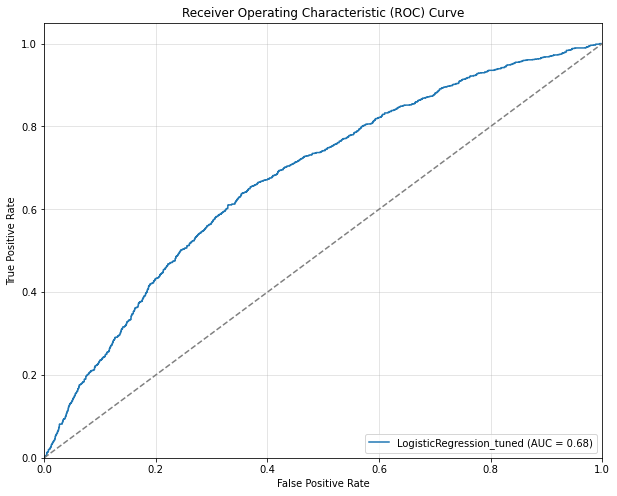

,AUROC,Precision,Recall,F1 Score
LogisticRegression_tuned,0.678098,0.636839,0.636942,0.634912


In [16]:
# check model performance
plot_roc_curve(tuned_models, Xtest, ytest)
eval_metrics(tuned_models, Xtest, ytest)

In [17]:
# export the trained model for reuse later
import pickle

# save the trained model to a file
with open('logreg_los.pkl', 'wb') as file:
    pickle.dump(logreg_los_tuned, file)

In [19]:
# compute the probability of patient ICU LOS
probability = logreg_los_tuned.predict_proba(X_combined)

In [20]:
# convert the output in dataframe
probability_df = pd.DataFrame(probability, columns=['less than 3 days', 'greater than or equal to 3 days'])
probability_df.head()

,less than 3 days,greater than or equal to 3 days
0,0.372746,0.627254
1,0.458207,0.541793
2,0.592683,0.407317
3,0.515459,0.484541
4,0.597674,0.402326


In [21]:
# combine with the original dataset
notes_update = pd.concat([notes_update, probability_df], axis=1)
print('Dimension of the dataframe: ', notes_update.shape)
notes_update.head()

Dimension of the dataframe:  (16322, 8)


,id,los_icu_class,text,los_icu,icu_death,text_embeddings,less than 3 days,greater than or equal to 3 days
0,20001305,less than 3 days,INDICATION: ___ with copd in resp distress in...,2.78,1,"[0.0495544821, -0.0371760167, -0.127426326, -0...",0.372746,0.627254
1,20001361,greater than or equal to 3 days,CHEST X-RAY DATED ___.\n\nCOMPARISON: None.\n...,6.05,0,"[0.0776797682, -0.31048429, -0.00207543001, 0....",0.458207,0.541793
2,20001770,less than 3 days,EXAMINATION: LIVER OR GALLBLADDER US (SINGLE ...,2.87,0,"[0.132888228, -0.191068441, -0.0299163219, 0.1...",0.592683,0.407317
3,20002506,greater than or equal to 3 days,EXAMINATION: CTA HEAD AND CTA NECK Q16 CT NEC...,6.56,0,"[0.00452079531, -0.232567102, 0.0254237894, 0....",0.515459,0.484541
4,20003491,less than 3 days,EXAMINATION: Chest radiograph\n\nINDICATION: ...,2.54,0,"[0.0784905553, -0.151299506, 0.0241509974, 0.0...",0.597674,0.402326


In [22]:
# export the concatenate data in csv format
notes_update.to_csv('../data/notes_with_los_probability.csv', index=False)